In [1]:
print('What\'s Up')

What's Up


# Notebook Imports

In [2]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image # PIL=Pillow (Image amnupulation and processing)
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [137]:
EXAMPLE_FILE =  'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FINAL = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FINAL = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)  # email structure

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
# system default encoding
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
# separating body from header

stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY' : classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()  # spam = 1

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [15]:
data.tail() # non spam = 0

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning: Checking for Missing Values

In [16]:
# Check if any message bodies are null
data['MESSAGE'].isnull().values.any() # In message col isnull(any missing) values(gives array) any(if any present)

False

In [17]:
type("")

str

In [18]:
len("")

0

In [19]:
my_var = None

In [20]:
type(my_var)

NoneType

In [21]:
# Check if an empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()   # any messege of strlen == 0

True

In [22]:
(data.MESSAGE.str.len() == 0).sum()

3

In [23]:
# Number of entries with null/None values
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [24]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [25]:
data[data.MESSAGE.str.len() == 0].index  # shows system files

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [26]:
# data.drop(['cmds'], inplace=True)  # removes system files
data[data.MESSAGE.str.len() == 0].index  # shows system files

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [27]:
data.shape

(5799, 2)

# Add Document IDs to Track Emails in Dataset

In [28]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [29]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [30]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5794,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5797,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [32]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [33]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

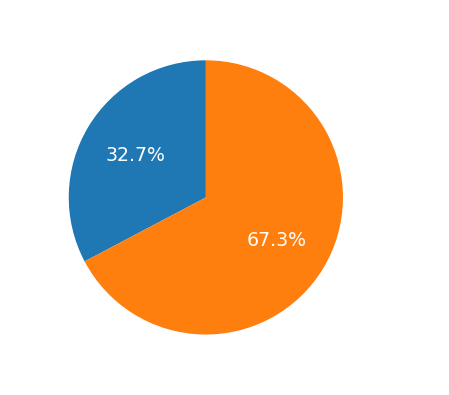

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6, 'color':'white'}, startangle=90,
       autopct='%1.1f%%')
plt.show()

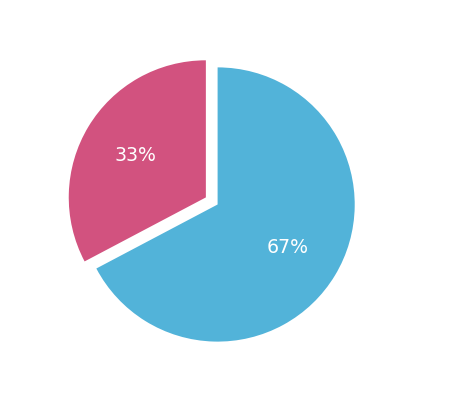

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors=['#d2527f', '#52b3d9']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6, 'color':'white'}, startangle=90,
       autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

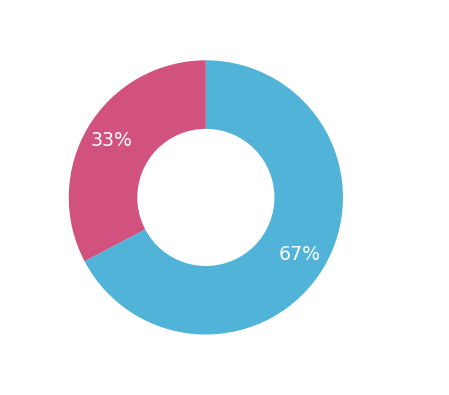

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors=['#d2527f', '#52b3d9']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6, 'color':'white'}, startangle=90,
       autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.5, fc='white')
plt.gca().add_artist(centre_circle)     # gca - get current axis

plt.show()

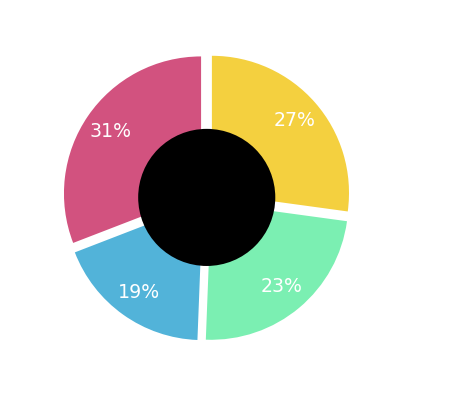

In [37]:
category_names = ['Spam', 'Legit Mail','Updates','Promotions']
sizes = [25, 15, 19, 22]
custom_colors=['#d2527f', '#52b3d9', '#7befb2', '#f4d03f']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6, 'color':'white'}, startangle=90,
       autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.5, fc='black')
plt.gca().add_artist(centre_circle)     # gca - get current axis

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [38]:
# Normalising case of letters (converting the text to lowercase)
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & Stopwords)

In [39]:
nltk.download('punkt') # downloading the punkt package in Appdata

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
nltk.download('stopwords') # downloading stopwords (Look at stopwords in folder)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
# download novel/plays from nltk
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [42]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower()) # tokenising and making lower

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words
#### (eg. the, I, of , a)

In [43]:
stop_words = set(stopwords.words('english'))  # set of stop words = starts with {} and seperatde with comma

In [44]:
type(stop_words)

set

In [45]:
if 'this' in stop_words: print('Found It!')

Found It!


In [46]:
if 'hello' not in stop_words: print('Nope, not in here')

Nope, not in here


In [47]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

# appending non-stop words to filtered_words
for word in words :
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [48]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english') # another woy of stemming if your language is not present use snowballstemmer

filtered_words = []

# appending non-stop words to filtered_words
for word in words :
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)  # makes is stemmed to make, Nobody = nobodi, expect & Inquisition also
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [49]:
'p'.isalpha() # built in method to check alphabets

True

In [50]:
'?'.isalpha()

False

In [51]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ???? \
        Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english') 
filtered_words = []

for word in words :
    if word not in stop_words and word.isalpha():  
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [52]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [53]:
soup.get_text()  # No HTML tags here

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Function for Email Processing

In [54]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits usp the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [55]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [56]:
# Modify function to remove HTML tags. Then test on Email with DOC_ID=11
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits usp the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word)
    
    return filtered_words

In [57]:
clean_msg_no_html(data.at[2, 'MESSAGE']) # just list of stemmed words no html

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [58]:
data.iat[100, 2]      # for selecting single message or single entry  in dataframe use 'iat' // in this case shows name of file at col=2

'00101.5a24bf3ba3962442179b1a0325a1d1cb'

In [59]:
data.iloc[5:11]   # shows 5-10 rows

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [60]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)  # Shows List of List / Series

In [61]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]  # loop inside the brackets which is appended in item workds sam as above


len(flat_list)

321

In [62]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 1min 10s


In [63]:
nested_list.head()

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [64]:
nested_list.tail()

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [65]:
data[data.CATEGORY == 1].shape  # number of spam messages

(1898, 3)

In [66]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1893,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1894,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1895,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1896,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5
1897,1,,cmds


In [67]:
# Create two variables (doc_ids_spam, doc_ids_ham) which holds onto the indicies for the spam and the non-spam emails respectively

In [68]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [69]:
print(doc_ids_ham)

print(doc_ids_spam)

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897],
           dtype='int64', name='DOC_ID', length=1898)


### Subsetting a Series with and Index

In [70]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [71]:
type(nested_list)

pandas.core.series.Series

In [157]:
# nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham = nested_list.reindex(doc_ids_ham)

In [158]:
nested_list_ham.shape

(3901,)

In [159]:
nested_list_ham.tail()

DOC_ID
5794    NaN
5795    NaN
5796    NaN
5797    NaN
5798    NaN
Name: MESSAGE, dtype: object

In [164]:
# nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam = nested_list.reindex(doc_ids_spam)

In [165]:
# Use python list comprehension and then find the total number of words in our cleaned dataset of spam email bodies. 
# Also find total number of words in normal email in the dataset. Then find the 10 most common words used in spam.
# Also, find the 10 most common words used in non-spam message.

In [166]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in non-spam messages

TypeError: 'float' object is not iterable

In [167]:
normal_words[:10]

NameError: name 'normal_words' is not defined

In [168]:
flat_list_ham = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in spam messages

TypeError: 'float' object is not iterable

In [80]:
spammy_words[:10]

NameError: name 'spammy_words' is not defined

# Creating a Word Cloud
#### github=> amueller/word_cloud (http://amueller.github.io/word_cloud/)

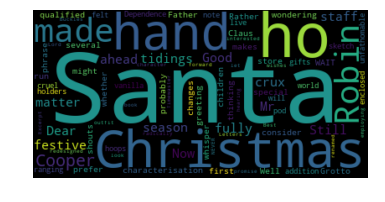

In [81]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)  # total words

260819

In [83]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [84]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [85]:
word_list= [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [86]:
# novel_as_string ## whole novel words below converted tro wordcloud

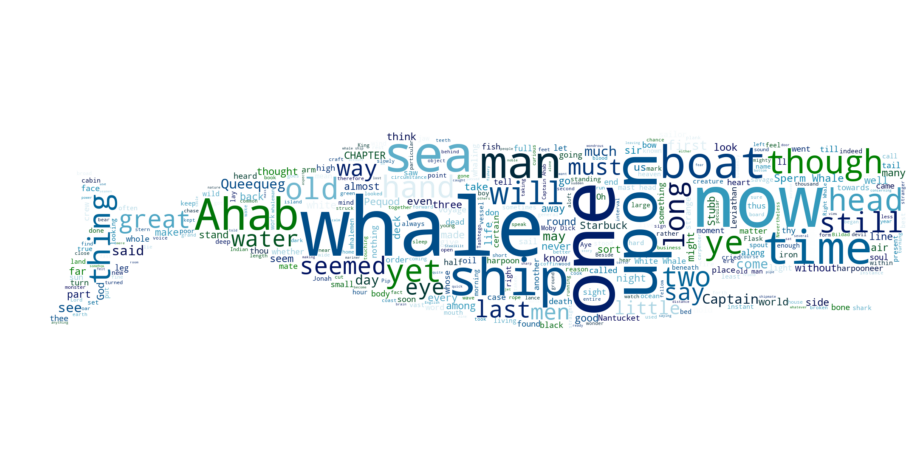

In [87]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)  # Converts image object to array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [88]:
rgb_array.shape # pixel by pixel information

(1024, 2048, 3)

In [89]:
rgb_array[1023, 2047]   # at this location pixel is black

array([255, 255, 255], dtype=uint8)

In [90]:
rgb_array[500, 1000]   # at this location pixel is black

array([0, 0, 0], dtype=uint8)

In [91]:
# using skull image and creating word cloud for shakespeare's play hamlet

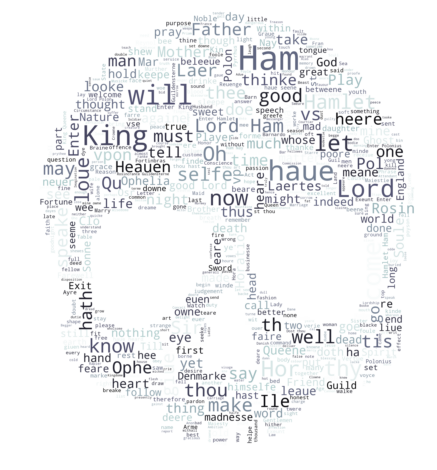

In [92]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

In [93]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)  # Converts image object to array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'flat_list_ham' is not defined

In [94]:
# Using custom fonts also.

In [95]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)  # Converts image object to array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                       max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spsam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'flat_list_spam' is not defined

# Generate Vocabulary & Dictionary

In [96]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [97]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr. of Upload words', unique_words.shape[0])
unique_words.head()

Nr. of Upload words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [98]:
# Subset of the series called : 'frequent_words' , that only contains the most common 2,500 words out of the total. Print top 10 words

In [99]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [100]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [101]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Checking if a Word is Part of the Vocabulary

In [102]:
# Checking if a particular word is a part of the vocabulary. True if yes in the 2500 vocabulary. If False then checking following words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'

In [103]:
any(vocab.VOCAB_WORD == 'data') # inefficient way

True

In [104]:
# By making set of finding words and using set function
'learn' in set(vocab.VOCAB_WORD)  # bettre way(computer time is less)

True

# Generating Features & a Sparse Matrix
### Creating a DataFrame with one Word per Column

In [105]:
type(stemmed_nested_list)

pandas.core.series.Series

In [106]:
type(stemmed_nested_list.tolist())

list

In [107]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [109]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [110]:
word_columns_df.shape

(5799, 7671)

### Splitting the Data into a Training and Testing Data

In [111]:
# Split the data into Train and Test Data and set the test size to 308. The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target value be?

In [112]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [113]:
print('Nr. of training samples', X_train.shape[0])
print('Fraction of Training Set', X_train.shape[0] / word_columns_df.shape[0])

Nr. of training samples 4059
Fraction of Training Set 0.6999482669425763


In [114]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,url,http,date,suppli,key,encod,photon,light,sent,kilometr,...,None,None,None,None,None,None,None,None,None,None
5233,dave,long,write,also,strike,long,livestock,genet,engin,dumber,...,None,None,None,None,None,None,None,None,None,None
5072,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,subject,...,None,None,None,None,None,None,None,None,None,None
1293,creditfix,access,clear,bad,credit,onlin,directli,convieni,watch,credit,...,None,None,None,None,None,None,None,None,None,None
4357,us,lister,recognis,damian,lewi,winter,band,brother,annoy,one,...,None,None,None,None,None,None,None,None,None,None


In [115]:
y_train.head()

DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [116]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [117]:
word_index.get_loc('thu')

395

In [118]:
def make_sparse_matrix(df, indexed_words, labels):
    '''
    Returns sparse matrix as dataframe.
    df: A datafram with words in columns with a document id as an index (X_test or X_train)
    indexed_words: index of words ordered by word id 
    label: category as a seties (y_train or y_test)
    '''
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word is word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 
                       'OCCURANCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [119]:
# It will show time how much time it takes....This code will definitely take 5-7min depending upon the machine you're using 

In [120]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 3min 39s


In [193]:
sparse_train_df[:5]

NameError: name 'sparse_train_df' is not defined

In [194]:
sparse_train_df.shape

NameError: name 'sparse_train_df' is not defined

In [195]:
sparse_train_df[-5:]

NameError: name 'sparse_train_df' is not defined

### Combine Occurances with the Pandas groupby()  method

In [172]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

NameError: name 'sparse_train_df' is not defined

In [173]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [174]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [129]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

NameError: name 'train_grouped' is not defined

In [130]:
train_grouped.taiol()

NameError: name 'train_grouped' is not defined

In [134]:
vocab.at[1923, 'VOCAB_WORD']

'complain'

In [135]:
data.MESSAGE[5795]

'> >-- be careful when using this one.) Also, that really cute thing \n\nthat\n\n> >Japanese AV girls do of leaving their panties on one leg while \n\nmaking love\n\n\n\nDare I ask what a Japanese "AV girl" is? \n\ntimh\n\n\n\n\n\n------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/46VHAA/7gSolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nTo unsubscribe from this group, send an email to:\n\nforteana-unsubscribe@egroups.com\n\n\n\n \n\n\n\nYour use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ \n\n\n\n\n\n\n'

In [136]:
train_grouped.shape

NameError: name 'train_grouped' is not defined

### Save Training Data as .txt File

In [138]:
np.savetxt(TRAINING_DATA_FINAL, train_grouped, fmt='%d')

NameError: name 'train_grouped' is not defined

In [139]:
train_grouped.columns

NameError: name 'train_grouped' is not defined

In [ ]:
# Creating a Sparse matrix for the test data. Group the occurance of the same word in the same email. Then save the data as a txt file

In [140]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,thu,jul,chad,norwood,wrote,steven,champeon,wrote,chad,progress,...,None,None,None,None,None,None,None,None,None,None
1103,webcredit,thank,email,address,obtain,ase,list,refer,wish,unsubscrib,...,None,None,None,None,None,None,None,None,None,None
812,hello,jm,growth,hormon,therapi,lose,weight,build,lean,muscl,...,None,None,None,None,None,None,None,None,None,None
1632,applic,grant,rememb,type,grant,never,need,repay,time,limit,...,None,None,None,None,None,None,None,None,None,None
1128,hey,like,tri,everyth,lose,weight,know,feel,special,diet,...,None,None,None,None,None,None,None,None,None,None


In [141]:
y_test.head()

DOC_ID
4925    0
1103    1
812     1
1632    1
1128    1
Name: CATEGORY, dtype: int64

In [143]:
X_test.shape

(1740, 7671)

In [144]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 1min 50s


In [145]:
sparse_test_df.shape

NameError: name 'sparse_test_df' is not defined

In [146]:
test_grouped = sparse_test_dfd.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

NameError: name 'sparse_test_dfd' is not defined

In [147]:
test_grouped.shape

NameError: name 'test_grouped' is not defined

In [148]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

NameError: name 'TEST_DATA_FILE' is not defined

# Pre-Processing Subtleties and Checking your Understanding

Started with 5796 emails. Split up it into 4057 emails for training and 1739 emails for testing.

How many indivisual emails were included in the testing .txt file? Count the numeber in the test_grouped DataFrame. 
After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number same? 
If not which emails excluded and why? Compare the DOC_ID values to find out.

In [150]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

NameError: name 'train_grouped' is not defined

In [151]:
len(train_doc_ids)

NameError: name 'train_doc_ids' is not defined

In [152]:
len(X_test)

1740

In [155]:
set(X_test.index.values) - test_doc_ids

NameError: name 'test_doc_ids' is not defined

In [179]:
data.MESSAGE[14]

'<HTML><HEAD><TITLE>Lowest Rate Services</TITLE>\n\n<META http-equiv=3DContent-Type content=3D"text/html; charset=3Dwindows-12=\n\n52">\n\n<META content=3D"MSHTML 5.50.4134.600" name=3DGENERATOR></HEAD>\n\n<BODY vLink=3D#c0c0c0 link=3D#c0c0c0 bgColor=3D#000033 leftMargin=3D0><FON=\n\nT \n\nface=3Darial,helvetica>\n\n<P>\n\n<CENTER>\n\n<TABLE width=3D600 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD align=3Dmiddle><B><FONT color=3D#999999 size=3D6>Conferencing Made=\n\n Easy</FONT><BR>\n\n<FONT color=3D#999999 size=3D5>Only <U>18 Cents</U> Per Minute!</B></FONT>=\n\n</TD></TR></TBODY></TABLE>\n\n<P><FONT color=3D#ff0000 size=3D5><B>(Including Long Distance!)</B></FONT>=\n\n \n\n<P>\n\n<TABLE width=3D350 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD><FONT color=3D#999999 size=3D3><B>\n\n      <LI>No setup fees \n\n      <LI>No contracts or monthly fees \n\n      <LI>Call anytime, from anywhere, to anywhere \n\n      <LI>Connects up to 100 Participants \n\n      <LI>Simplicity in set up a

In [180]:
data.loc[14]

CATEGORY                                                     1
MESSAGE      <HTML><HEAD><TITLE>Lowest Rate Services</TITLE...
FILE_NAME               00015.048434ab64c86cf890eda1326a5643f5
Name: 14, dtype: object

In [189]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['lowest',
 'rate',
 'servic',
 'conferenc',
 'easi',
 'cent',
 'per',
 'minut',
 'includ',
 'long',
 'distanc',
 'setup',
 'fee',
 'contract',
 'monthli',
 'fee',
 'call',
 'anytim',
 'anywher',
 'anywher',
 'connect',
 'particip',
 'simplic',
 'set',
 'administr',
 'oper',
 'help',
 'avail',
 'highest',
 'qualiti',
 'servic',
 'lowest',
 'rate',
 'industri',
 'fill',
 'form',
 'low',
 'find',
 'lower',
 'phone',
 'bill',
 'everi',
 'requir',
 'input',
 'web',
 'address',
 'compani',
 'busi',
 'home',
 'phone',
 'email',
 'type',
 'busi',
 'remov',
 'distribut',
 'list',
 'pleas',
 'click']

In [190]:
data.MESSAGE[1096]

'<HTML><BR><FONT  COLOR=3D"#ff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COL=\n\nOR: #ffffff" SIZE=3D3 PTSIZE=3D12><center>x=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3D=\n\nxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dx</cen=\n\nter><br><br><i><b>Absolutely Awesome!!</b></i><br><br><!--#rotate> <b> Ins=\n\ntantly </FONT><FONT  COLOR=3D"#ff0000" BACK=3D"#ff80ff" style=3D"BACKGROUN=\n\nD-COLOR: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial"=\n\n LANG=3D"0"> &nbsp;S e x u a l l y  Attract</FONT></FONT><FONT  COLOR=3D"#=\n\nff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COLOR: #ffffff" SIZE=3D3 PTSI=\n\nZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D"0"> with nature\'s secr=\n\net weapon..." P  h  e  r  o  m  o n  e  s"<BR>\n\n<BR><BR>\n\n"I n v i s i b l e   a n d   u n d e t e c t a b l e" , when unknowingly i=\n\nnhaled, Pheromone Concentrate  unblocks all restraints and releases the ra=\n\nw  animal s e x drive!<BR>\n\n<BR> <BR> \n\nThis is the strongest

In [191]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

['awesom',
 'rotat',
 'tantli',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'natur',
 'et',
 'weapon',
 'p',
 'h',
 'e',
 'r',
 'n',
 'e',
 'n',
 'v',
 'b',
 'l',
 'e',
 'n',
 'u',
 'n',
 'e',
 'e',
 'c',
 'b',
 'l',
 'e',
 'unknowingli',
 'nhale',
 'pheromon',
 'concentr',
 'unblock',
 'restraint',
 'releas',
 'w',
 'anim',
 'e',
 'x',
 'drive',
 'strongest',
 'concentr',
 'human',
 'allow',
 'law',
 'essenti',
 'oil',
 'base',
 'avail',
 'formula',
 'men',
 'women',
 'click',
 'attract',
 'e',
 'mail',
 'list',
 'pleas',
 'email',
 'us',
 'p',
 'rand',
 'sspltm',
 'pheromon',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'women',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'men',
 'attract',
 'men',
 'ttract',
 'women',
 'men',
 'instantli',
 'attract',
 'women',
 'men',
 'becom',
 'fast',
 'gain',
 'sexual',
 'advantag',
 'power',
 'power',
 'becom',
 'desir']

In [192]:
clean_message(data.at[1096, 'MESSAGE'])

['html',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'center',
 'ter',
 'br',
 'br',
 'b',
 'absolut',
 'awesom',
 'br',
 'br',
 'rotat',
 'b',
 'tantli',
 'font',
 'sansserif',
 'arial',
 'nbsp',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'natur',
 'et',
 'weapon',
 'p',
 'h',
 'e',
 'r',
 'n',
 'e',
 'br',
 'br',
 'br',
 'n',
 'v',
 'b',
 'l',
 'e',
 'n',
 'u',
 'n',
 'e',
 'e',
 'c',
 'b',
 'l',
 'e',
 'unknowingli',
 'nhale',
 'pheromon',
 'concentr',
 'unblock',
 'restraint',
 'releas',
 'w',
 'anim',
 'e',
 'x',
 'drive',
 'br',
 'br',
 'br',
 'strongest',
 'concentr',
 'font',
 'sansserif',
 'arial',
 'human',
 'pheromon',
 'font',
 'ffffff',
 'ff',
 'sansserif',
 'arial',
 'allow',
 'law',
 'essenti',
 'oil',
 'br',
 'br',
 'br',
 'avail',
 'formula',
 'men',
 'br',
 'br',
 'br',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'http',
 'click',
 'attract',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'font',
